## 4. GLMのモデル選択
- [introduction_to_statistical_modeling_for_data_analysis/chapter4.ipynb](https://github.com/ohke/introduction_to_statistical_modeling_for_data_analysis/blob/master/chapter4.ipynb)

In [36]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import polars as pl
import os

In [37]:
file_path = './data/data3a.csv'

if not os.path.isfile(file_path):
  response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/poisson/data3a.csv')
  with open (file_path, 'wb') as f:
      f.write(response.content)
      f.close()

df = pl.read_csv(file_path)
df.head()

y,x,f
i64,f64,str
6,8.31,"""C"""
6,9.44,"""C"""
6,9.5,"""C"""
12,9.07,"""C"""
10,10.16,"""C"""


In [38]:
f2id = {'C': 0, 'T': 1}

# メモリの節約(今回はデータ数が少ないのでする必要はないけど、good practiceとして)
df = df.with_columns(
  [
    pl.col('y').cast(pl.datatypes.Int16),
    pl.col('x').cast(pl.datatypes.Float32),
    pl.col('f').apply(lambda x: f2id[x]).alias('f2').cast(pl.datatypes.Int8)
  ]
)
df.head()

y,x,f,f2
i16,f32,str,i8
6,8.31,"""C""",0
6,9.44,"""C""",0
6,9.5,"""C""",0
12,9.07,"""C""",0
10,10.16,"""C""",0


### 4.2 統計モデルのあてはまりの悪さ: 逸脱度

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

#### xモデル

In [40]:
x_model = smf.glm(formula='y ~ x', data=df, family=sm.families.Poisson())

# logλ(i) = β1 + β2 * x(i) 
# 当てはまりの良さ(対数尤度): -235.39
# β1(Intercept: 切片)の最尤推定値: 1.29
# β2(xの傾き)の最尤推定値: 0.0757
#------------------------------
# Deviance: 残差逸脱度: 84.993
# 逸脱度: 最大対数尤度 * -2: -235.39 * 2
print(x_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Sat, 04 Feb 2023   Deviance:                       84.993
Time:                        12:27:29   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04414
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.0

#### nullモデル

In [41]:
null_model = smf.glm(formula='y ~ 1', data=df, family=sm.families.Poisson())

# Deviance: 残差逸脱度: 89.507
# 逸脱度: 最大対数尤度 * -2: -237.64 * 2
# 残差逸脱度がxモデルの(84.993)より大きくなっている
print(null_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Sat, 04 Feb 2023   Deviance:                       89.507
Time:                        12:27:29   Pearson chi2:                     87.1
No. Iterations:                     4   Pseudo R-squ. (CS):         -1.776e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0580      0.036     57.586      0.0

### 4.3 AIC(Akaie's information criterison)
```
AIC = -2 x{(最大対数尤度) - (最尤推定したpらメーター数)}
    = -2 (LogL* - K)
    = D(逸脱度) + 2k
```

In [42]:
f_model = smf.glm(formula='y ~ f2', data=df, family=sm.families.Poisson())
print(f_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Sat, 04 Feb 2023   Deviance:                       89.475
Time:                        12:27:29   Pearson chi2:                     87.1
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0003192
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0516      0.051     40.463      0.0

In [43]:
xf_model = smf.glm(formula='y ~ x + f2', data=df, family=sm.families.Poisson())
print(xf_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Sat, 04 Feb 2023   Deviance:                       84.808
Time:                        12:27:29   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04590
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.0

|  model  |  最大対数尤度  | パラメータ数|
| ---- | ---- | --- |
|  null model  | -237.64  | 1 |
|  x model | -235.39  | 2 |
|  f model  | -237.63  | 2|
|  x f model  | -235.29 | 3 |

In [44]:
# AIC
print('null model: ', -237.64 * -2 + 2 * 1)
print('x model: ', -235.39 * -2 + 2 * 2)
print('f model: ', -237.63 * -2 + 2 * 2)
print('x f model: ', -235.29 * -2 + 2 * 3)

null model:  477.28
x model:  474.78
f model:  479.26
x f model:  476.58


In [45]:
# AICメソッドは用意されている
print('null model: ', null_model.fit().aic)
print('x model: ', x_model.fit().aic)
print('f model: ', f_model.fit().aic)
print('x f model: ', xf_model.fit().aic)


null model:  477.2864426185736
x model:  474.77250257855667
f model:  479.25451392137376
x f model:  476.5874395411329


### 4.5 なぜAICでモデル選択して良いか？

In [46]:
# 「真の値」をポアソン分布で作成する
l = 8 
y = np.random.poisson(l, 50)
data = pl.DataFrame(y, columns=['y'])
data.describe()

describe,y
str,f64
"""count""",50.0
"""null_count""",0.0
"""mean""",8.54
"""std""",3.586881
"""min""",2.0
"""max""",21.0
"""median""",8.0


In [47]:
# 最尤推定でパラメータを決定: 推測
null_model = smf.glm(formula='y ~ 1', data=data, family=sm.families.Poisson())
result = null_model.fit()
print(result.summary())
print(np.exp(result.params[0])) # リンク関数に対数を利用しているので
print(result.llf)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.09
Date:                Sat, 04 Feb 2023   Deviance:                       70.190
Time:                        12:27:30   Pearson chi2:                     73.8
No. Iterations:                     4   Pseudo R-squ. (CS):          2.220e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1448      0.048     44.319      0.0

In [48]:
import pandas as pd
import math

# 真のモデルから200セットのデータを生成
data_random_200 = [pd.DataFrame(np.random.poisson(8, len(data)), columns=['y']) for i in range(200)]

# 200セットのデータに対して、推測したモデルの切片を利用して200個の対数尤度を計算
lls = []
for d in data_random_200:
    lls.append(sum(poisson.logpmf(d, math.exp(result.params['Intercept']))))
    
# 平均対数尤度を計算
elogl = np.sum(lls) / len(lls)
print('E(log L):', elogl)

E(log L): -123.80753474542347


In [49]:
# 1セットの最大対数尤度と200セットの平均対数尤度を200回ずつ計測する
# どれくらい対数尤度にぶれがあるのか？
logls = []
elogls = []

for i in range(200):
    data_random = pd.DataFrame(np.random.poisson(8, 50), columns=['y'])
    
    results = smf.poisson('y ~ 1', data=data_random).fit(disp=0)
    logls.append(results.llf)
    
    data_random_200 = [pd.DataFrame(np.random.poisson(8, len(data_random)), columns=['y']) for i in range(200)]
    
    lls = []
    for d in data_random_200:
        lls.append(sum(poisson.logpmf(d, math.exp(results.params['Intercept']))))
    elogls.append(np.sum(lls) / len(lls))

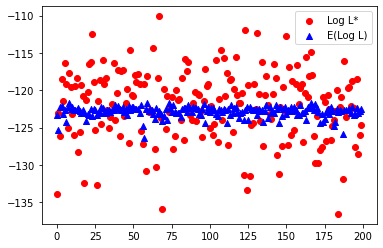

In [50]:
# 最大対数尤度(赤○)と平均対数尤度(青▲)を散布図でプロット
x = np.arange(200)
plt.scatter(x, logls, color='red', marker='o', label='Log L*')
plt.scatter(x, elogls, color='blue', marker='^', label='E(Log L)')
plt.legend(loc='best')
plt.show()

In [51]:
# 最大対数尤度と平均対数尤度の標本平均の差(=バイアス)を計算
# バイアス: 推定用データのあてまりの良さである「最大対数尤度」 - 予測の良さを表す「平均対数尤度」
# => AICはバイアスの値を考慮されているこということになる
b = np.average(logls) - np.average(elogls)
print('Bias:', b)

Bias: 0.8640437961096978


### 4.5.3 ネスとしているGLM間のAIC比較

In [52]:
# 200セットのデータに対して一定モデルとxモデルで、最大対数尤度と平均対数尤度を計算
logls = []
elogls = []
xlogls = []
xelogls = []

for i in range(200):
    # 説明変数と目的変数が無関係の観測データ1セットを作る
    data_random = pd.concat(
        [pd.DataFrame(np.random.poisson(8, 50), columns=['y']), pd.DataFrame(np.random.rand(50)*9+1, columns=['x'])], 
        axis=1)
    
    # 一定モデルによる最尤推定
    results = smf.poisson('y ~ 1', data=data_random).fit(disp=0)
    logls.append(results.llf)
    
    # xモデルによる最尤推定
    xresults = smf.poisson('y ~ x', data=data_random).fit(disp=0)
    xlogls.append(xresults.llf)
    
    # 真のモデルから新たなデータ200セットを作る
    data_random_200 = [pd.concat(
        [pd.DataFrame(np.random.poisson(8, 50), columns=['y']), pd.DataFrame(np.random.rand(50)*9+1, columns=['x'])], 
        axis=1) for i in range(200)]    

    # 200セットの対数尤度を計算
    lls = []
    xlls= []
    for d in data_random_200:
        lls.append(sum(poisson.logpmf(d['y'], math.exp(results.params['Intercept']))))
        xlls.append(sum(poisson.logpmf(d['y'], np.exp(xresults.params['Intercept'] + d['x'] * xresults.params['x']))))
        
    # 平均対数尤度を計算
    elogls.append(np.average(lls))
    xelogls.append(np.average(xlls))

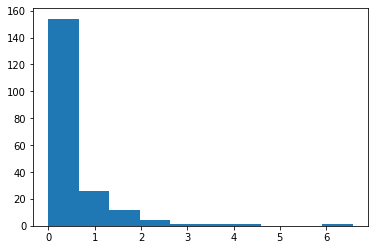

0.5071740360680429


In [53]:
# 最大対数尤度の差
logls_diff = np.subtract(xlogls, logls)

plt.hist(logls_diff, bins=10)
plt.show()

# 最大対数尤度の差の平均
print(np.average(logls_diff))

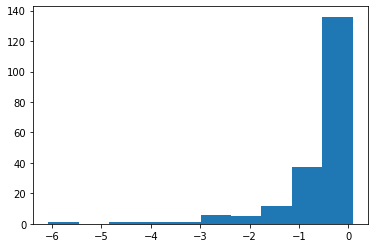

-0.5451770373835729


In [54]:
# 平均対数尤度の差
elogls_diff = np.subtract(xelogls, elogls)

plt.hist(elogls_diff, bins=10)
plt.show()

# 平均対数尤度の差の平均
print(np.average(elogls_diff))

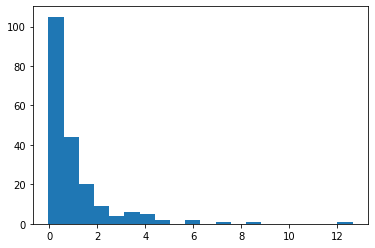

1.0523510734516157


In [55]:
# バイアスの差
b_diff = logls_diff - elogls_diff

plt.hist(b_diff, bins=20)
plt.show()

# バイアスの差の平均
print(np.average(b_diff))

In [56]:
# 一定モデルのAIC
aic = -2 * logls[0] + 2
print(aic)

238.59194709527614


In [57]:
# xモデルのAIC
aic = -2 * xlogls[0] + 4
print(aic)

239.6912769737122
